In [11]:
using Serialization, Statistics, Distributions, StableRNGs, CSV, ForwardDiff, GlobalSensitivity
include("misc.jl")
include("ode_problem.jl")
include("target_probability.jl")
include("marginal_kl_divergence.jl")
include("define_likelihood_data.jl")
include("sensitivity_analysis.jl");

RNG

In [2]:
rng = StableRNG(34627);

Input Run Details

In [3]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run = "220"
baseline_run = "201"
prior_nonbinding_offset = [2,2]
prior_binding_offset = [0,0];

In [35]:
#for analysis needing pairs (augmented and baseline comparison)
augmented_run = "204"
baseline_run = "205"
#prior_nonbinding_offset  = [1,1]
#prior_binding_offset = [0,0] #will be set later
bound_offset = [1,1]
binding_bound_offset = [0,0]; #will be set later
prior_bounds = return_prior_bounds_empirical(bound_offset, binding_bound_offset) #for target probability
#redefine narrow koff bounds
koff_i = return_koff_indices()
prior_bounds[koff_i] = return_prior_bounds_empirical(bound_offset, [-2,0])[koff_i] 
#redefine k12b bounds, so that reported value is within the prior bounds
prior_bounds[koff_i[2]] = return_prior_bounds_empirical(bound_offset, [-1,-1])[koff_i[2]] 
#redefine narrow kon bounds
kon_i = return_kon_indices()
prior_bounds[kon_i] = return_prior_bounds_empirical(bound_offset, [-1,-1])[kon_i]
#redefine k13f bounds, so that reported value is within the prior bounds
prior_bounds[kon_i[3]] = return_prior_bounds_empirical(bound_offset, [-2,0])[kon_i[3]];

In [36]:
augmented_run = "202"
baseline_run = "203"
bound_offset = [3,3]
binding_bound_offset = [1,1]
prior_bounds = return_prior_bounds_empirical(bound_offset, binding_bound_offset); #for target probability

50-element Vector{Vector{Float64}}:
 [-0.4685210829577451, 5.531478917042255]
 [-1.3010299956639813, 4.698970004336019]
 [-1.0, 5.0]
 [-2.769551078621726, 3.230448921378274]
 [-0.3467874862246565, 5.653212513775344]
 [-3.0, 3.0]
 [-7.0, 1.0]
 [-5.0, 1.0]
 [-5.346787486224656, 0.6532125137753435]
 [-4.522878745280337, 1.4771212547196624]
 [-7.0, 1.0]
 [-5.0, 1.0]
 [-7.0, 1.0]
 ⋮
 [-4.0, 2.0]
 [-5.0, 1.0]
 [-5.0, 1.0]
 [-3.0, 3.0]
 [-7.0, 1.0]
 [-5.0, 1.0]
 [-4.301029995663981, 1.6989700043360187]
 [-3.0, 3.0]
 [-5.221848749616356, 0.7781512503836439]
 [-3.5228787452803374, 2.4771212547196626]
 [-7.0, 1.0]
 [-5.0, 1.0]

Define Prior for Analyses

Calculate Quantiles of Posteriors

In [37]:
#load posterior samples - change name as necessary 
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)

#define priors
#prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset)

#parameter names
parameter_names = return_inferred_parameters()

#ground truth value on log10 scale
ground_truth = log10.(groundtruth_parameter_values())

#calculate quantiles
lower_bound = 0.05
upper_bound = 0.95
my_quantiles = [[Statistics.quantile(baseline_samples[i,:], lower_bound), Statistics.quantile(baseline_samples[i,:], upper_bound)] for i in 1:n_parameters]
my_quantiles_aug = [[Statistics.quantile(aug_samples[i,:], lower_bound), Statistics.quantile(aug_samples[i,:], upper_bound)] for i in 1:n_parameters]
my_quantiles_priors = []
for i in 1:n_parameters
    bounds = prior_bounds[i]
    difference = bounds[2] - bounds[1]
    quantiles_offset = difference*lower_bound
    push!(my_quantiles_priors, [bounds[1]+quantiles_offset, bounds[2]-quantiles_offset])
end

#save 
serialize("outputs/600_$(baseline_run)_posterior_quantiles.jls", my_quantiles)
serialize("outputs/600_$(augmented_run)_posterior_quantiles.jls", my_quantiles_aug)
serialize("outputs/600_$(augmented_run)_prior_quantiles.jls", my_quantiles_priors)

Mean Absolute Error w.r.t. Posterior Samples

In [38]:
#load posterior samples
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)

#parameter names
parameter_names = return_inferred_parameters()

#ground truth value on log10 scale
ground_truth = log10.(groundtruth_parameter_values())

#calculate absolute error of each sample
abs_error = Base.stack([abs.(baseline_samples[:,i] .- ground_truth) for i in 1:n_samples])
abs_error_reg = Base.stack([abs.(aug_samples[:,i] .- ground_truth) for i in 1:n_samples])

#take mean of absolute errors for each parameter
mae = [sum(abs_error[i,:])/n_samples for i in 1:n_parameters]
mae_reg = [sum(abs_error_reg[i,:])/n_samples for i in 1:n_parameters]

#convert to dictionary
mae_dict = Dict(parameter_names[i] => mae[i] for i in 1:n_parameters)
mae_aug_dict = Dict(parameter_names[i] => mae_reg[i] for i in 1:n_parameters)

#save 
serialize("outputs/600_$(baseline_run)_mean_absolute_error.jls", mae_dict)
serialize("outputs/600_$(augmented_run)_mean_absolute_error.jls", mae_aug_dict)

Calculate KL Divergence for From Augmented to Baseline Posterior

In [39]:
#load posterior samples
aug_samples = deserialize("outputs/300_$(augmented_run)_posterior_samples_thinned.jls") #ndims x nsamples
baseline_samples = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls") #ndims x nsamples 
n_parameters, n_samples = size(aug_samples)
#prior_bounds = return_prior_bounds_empirical(prior_nonbinding_offset, prior_binding_offset)
prior_distributions = [Uniform(prior_bounds[i]...) for i in 1:n_parameters]
prior_samples = transpose(Base.stack([rand(rng, prior_distributions[i], n_samples) for i in 1:n_parameters])) #ndims x nsamples 

#parameter names
parameter_names = return_inferred_parameters()
kl_div_augmented_baseline, parameter_names = kl_divergence_bits_samples(aug_samples, baseline_samples, parameter_names)
kl_div_baseline_prior, parameter_names = kl_divergence_bits_samples(baseline_samples, prior_samples, parameter_names)

#save
serialize("outputs/600_$(augmented_run)_$(baseline_run)_kl_div.jls", kl_div_augmented_baseline)
serialize("outputs/600_$(baseline_run)_prior_kl_div.jls", kl_div_augmented_baseline)

Calculate quantiles of finegrain predictions for which we have experimental data

In [40]:
data_files = readdir("data")
sort_files = data_files .!= ".DS_Store"
data_files = sort(data_files[sort_files]) #sort to ensure consistent order
sort_files = data_files .!= "kholodenko1.xml"
data_files = sort(data_files[sort_files])
sort_files = data_files .!= "predicted_kd.csv"
data_files = sort(data_files[sort_files])
quantity_names = [replace(data_files[i], ".csv" => "") for i in 1:length(data_files)];

In [41]:
for r in [augmented_run, baseline_run]    
    for i in quantity_names
        predictions = Base.stack(deserialize("outputs/500_$(r)_finegrain_predictions_$(i).jls")) #ntime x n
        n_time_points, n_predictions = size(predictions)
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        serialize("outputs/600_$(r)_prediction_quantiles_$(i).jls", Dict("lower_quantile"=>quantile_low, 
        "median"=>median, "upper_quantile" =>quantile_up))
    end
end

Calculate Quantiles of Predictions for All Species

In [42]:
#calculate quantiles
for r in [augmented_run, baseline_run]
    all_predictions = deserialize("outputs/500_$(r)_predictions.jls")
    n_doses, n_samples = size(all_predictions)
    n_species = length(all_predictions[1].u[1])
    n_time_points = length(all_predictions[1].u);
    reshaped_predictions = []
    for i in 1:n_doses
        p_per_dose = all_predictions[i,:]
        for z in 1:n_species
            species_dose = zeros(n_time_points, n_samples)
            for j in 1:n_samples
                species_dose[:,j] = Base.stack(p_per_dose[j].u)[z,:]
            end
            reshaped_predictions = cat(reshaped_predictions, [Base.stack(species_dose)], dims=1)
        end
    end
    quantiles = []   
    for j in 1:(n_doses*n_species)
        predictions = reshaped_predictions[j]
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        quantiles = cat(quantiles, [Dict("lower_quantile"=>quantile_low, "median"=>median, "upper_quantile" =>quantile_up)], dims=1)
    end
    serialize("outputs/600_$(r)_prediction_quantiles.jls", quantiles)
end

In [43]:
#calculate quantiles for finegrain predictions - this is for plotting
for r in [augmented_run, baseline_run]
    all_predictions = deserialize("outputs/500_$(r)_predictions_finegrain.jls")
    n_doses, n_samples = size(all_predictions)
    n_species = length(all_predictions[1].u[1])
    n_time_points = length(all_predictions[1].u);
    reshaped_predictions = []
    for i in 1:n_doses
        p_per_dose = all_predictions[i,:]
        for z in 1:n_species
            species_dose = zeros(n_time_points, n_samples)
            for j in 1:n_samples
                species_dose[:,j] = Base.stack(p_per_dose[j].u)[z,:]
            end
            reshaped_predictions = cat(reshaped_predictions, [Base.stack(species_dose)], dims=1)
        end
    end
    quantiles = []   
    for j in 1:(n_doses*n_species)
        predictions = reshaped_predictions[j]
        uq = 0.95
        lq = 0.05
        m = 0.5
        quantile_up = [Statistics.quantile(predictions[i,:], uq) for i in 1:n_time_points]
        quantile_low = [Statistics.quantile(predictions[i,:], lq) for i in 1:n_time_points]
        median = [Statistics.quantile(predictions[i,:], m) for i in 1:n_time_points]
        quantiles = cat(quantiles, [Dict("lower_quantile"=>quantile_low, "median"=>median, "upper_quantile" =>quantile_up)], dims=1)
    end
    serialize("outputs/600_$(r)_prediction_quantiles_finegrain.jls", quantiles)
end 

Local Sensitivity Analysis

In [12]:
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]

#calculate local sensitivity of each species about this parameter value 
egf_doses = return_ligand_dose_order_for_likelihood_w_pshc_test()
n_doses = length(egf_doses)
n_species = 23
solver_inputs = return_ode_problem_solver_default_inputs()
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9
local_sensitivity_kb = []
local_sensitivity_kf = []
local_sensitivity_nonbinding = []
for i in 1:n_doses 
    odesys, u0, tspan, p = return_ode_problem_default_inputs(egf_doses[i])
    odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
    for j in 1:n_species
        local_sensitivity = ForwardDiff.jacobian(p -> local_sensitivity_analysis(p, odeprob, solver_inputs, j), max_likelihood_parameters) #take parameters out of log10scale first
        local_sensitivity_kb = cat(local_sensitivity_kb, [local_sensitivity[:,return_koff_indices()]], dims=1)
        local_sensitivity_kf = cat(local_sensitivity_kf, [local_sensitivity[:, return_kon_indices()]], dims=1)
        local_sensitivity_nonbinding = cat(local_sensitivity_nonbinding, [local_sensitivity[:, return_nonbinding_indices()]], dims=1)
    end
end
serialize("outputs/600_$(baseline_run)_local_sensitivity_kb.jls", local_sensitivity_kb)
serialize("outputs/600_$(baseline_run)_local_sensitivity_kf.jls", local_sensitivity_kf)
serialize("outputs/600_$(baseline_run)_local_sensitivity_nonbind.jls", local_sensitivity_nonbinding)


#reshape and save for correlation calculation between change in median and local sensitivity of parameters
#calculate absolute difference between medians for each output of interest
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")[1:end] # [1:46] exclude third dose. Third dose has only one training species timecourse, EGFR, and that timecourse is not well recapitulated
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")[1:end] #exclude third dose. Third dose has only one training species timecourse, EGFR, and that timecourse is not well recapitulated
n_outputs = length(augmented_quantiles) #n_species x n_doses
n_timepoints = length(augmented_quantiles[1]["median"])
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end
#save
med_dif = reshape(Base.stack(difference_between_medians), n_outputs*n_timepoints)
serialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls", med_dif)

#load local sensitivity to parameter for each output of interest, reshape to match median difference, save
for i in ["kb", "kf", "nonbind"]
    local_sensitivity_kb = deserialize("outputs/600_$(baseline_run)_local_sensitivity_$(i).jls") #vector of n_outputs, each output is sensitivity matrix of n_timepoints x n_parameters
    #maximum across kb
    max_ls_kb = []
    for i in 1:n_outputs
        max_ls_kb = cat(max_ls_kb, [vec(maximum(abs.(local_sensitivity_kb[i]), dims=2))], dims=1) #take parameter with highest sensitivity for particular output
    end
    ls_kb = reshape(Base.stack(max_ls_kb), n_outputs*n_timepoints)
    serialize("outputs/600_$(baseline_run)_local_sensitivity_$(i)_1d.jls", ls_kb)
end

Relative Local Sensitivity Analysis

In [41]:
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]

#calculate local sensitivity of each species about this parameter value 
egf_doses = return_ligand_dose_order_for_likelihood_w_pshc_test()
n_doses = length(egf_doses)
n_species = 23
solver_inputs = return_ode_problem_solver_default_inputs()
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9
local_sensitivity_kb = []
local_sensitivity_kf = []
local_sensitivity_nonbinding = [] 
for i in 1:n_doses 
    odesys, u0, tspan, p = return_ode_problem_default_inputs(egf_doses[i])
    odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters will be redefined in next function
    for j in 1:n_species
        local_sensitivity = ForwardDiff.jacobian(p -> local_sensitivity_analysis_absolute(p, odeprob, solver_inputs, j), 10.0.^max_likelihood_parameters) #take parameters out of log10scale first
        #multiple by 5% change in parameter value 
        n_outputs, n_parameters = size(local_sensitivity)
        percent_change = transpose(reshape(repeat((10.0.^max_likelihood_parameters).*0.05, n_outputs),n_parameters, n_outputs))
        local_sensitivity = local_sensitivity.*percent_change
        local_sensitivity_kb = cat(local_sensitivity_kb, [local_sensitivity[:,return_koff_indices()]], dims=1)
        local_sensitivity_kf = cat(local_sensitivity_kf, [local_sensitivity[:, return_kon_indices()]], dims=1)
        local_sensitivity_nonbinding = cat(local_sensitivity_nonbinding, [local_sensitivity[:, return_nonbinding_indices()]], dims=1)
    end
end
serialize("outputs/600_$(baseline_run)_5_percent_change_kb.jls", local_sensitivity_kb)
serialize("outputs/600_$(baseline_run)_5_percent_change_kf.jls", local_sensitivity_kf)
serialize("outputs/600_$(baseline_run)_5_percent_change_nonbind.jls", local_sensitivity_nonbinding)


#reshape and save for correlation calculation between change in median and local sensitivity of parameters
#calculate absolute difference between medians for each output of interest
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")[1:end] # [1:46] exclude third dose. Third dose has only one training species timecourse, EGFR, and that timecourse is not well recapitulated
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")[1:end] #exclude third dose. Third dose has only one training species timecourse, EGFR, and that timecourse is not well recapitulated
n_outputs = length(augmented_quantiles) #n_species x n_doses
n_timepoints = length(augmented_quantiles[1]["median"])
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end
#save
med_dif = reshape(Base.stack(difference_between_medians), n_outputs*n_timepoints)
serialize("outputs/600_$(baseline_run)_$(augmented_run)_difference_between_medians_1d.jls", med_dif)

#load local sensitivity to parameter for each output of interest, reshape to match median difference, save
for i in ["kb", "kf", "nonbind"]
    local_sensitivity_kb = deserialize("outputs/600_$(baseline_run)_5_percent_change_$(i).jls") #vector of n_outputs, each output is sensitivity matrix of n_timepoints x n_parameters
    #maximum across kb
    max_ls_kb = []
    for i in 1:n_outputs
        max_ls_kb = cat(max_ls_kb, [vec(maximum(abs.(local_sensitivity_kb[i]), dims=2))], dims=1) #take parameter with highest sensitivity for particular output
    end
    ls_kb = reshape(Base.stack(max_ls_kb), n_outputs*n_timepoints)
    serialize("outputs/600_$(baseline_run)_5_percent_change_$(i)_1d.jls", ls_kb)
end

Global Sensitivity Analysis about Max Likelihood Parameters

In [71]:
#global sensitivity analysis about maximum likelihood parameter set 
#first, extract parameter set that maximizes baseline training data likelihood
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
n_parameters = length(max_likelihood_parameters)
n_species = 23

#ode problem definition
ligand_doses = return_ligand_dose_order_for_likelihood_w_pshc_test()
n_doses = length(ligand_doses)
solver_inputs = return_ode_problem_solver_default_inputs()
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[1]) #dose will be set later, this is simply to define ode problem
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function

#ode solver inputs
solver_inputs = return_ode_problem_solver_default_inputs()
solver_inputs["reltol"] = 1.0e-12
solver_inputs["abstol"] = 1.0e-9
solver_inputs["saveat"] = [15 30 45 60 120] #redefine to exclude tp 0

#sensitivity analysis parameters
#initial conditions first
#vary non-zero initial conditions by an order of magnitude
non_zero_ic_mask = u0 .!= 0.0
non_zero_ic_mask[1] = 0 #exclude ligand dose
non_zero_ic = u0[non_zero_ic_mask] #exclude ligand dose
n_ic = length(non_zero_ic)
non_zero_ic = log10.(non_zero_ic)
lb_ic = non_zero_ic.-1
ub_ic = non_zero_ic.+1
bounds_ic = [[lb_ic[i],ub_ic[i]] for i in 1:n_ic];
#get parameter bounds based on max likelihood parameters
lb = max_likelihood_parameters.-1
ub = max_likelihood_parameters.+1
bounds = [[lb[i],ub[i]] for i in 1:50]
push!(bounds, [-2,0]) #dummy parameter
total_bounds = cat(bounds_ic, bounds, dims=1) #all bounds to vary 
total_bounds = total_bounds #exclude ligand dose, which we set for comparison with simulations 

Ns = 10000 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 56 (number of parameters) 
#calculate local sensitivity of each species about this parameter value 
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species, non_zero_ic_mask), eFAST(), total_bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

Global Sensitivity Analysis using Prior Bounds

In [47]:
#global sensitivity analysis with priors
bounds = sensitivity_analysis_bounds([2,2],[0,0])
Ns = 10000 #sample size, needs to be bigger than 2*num_harmonics*omega_max, where num_harmonics = 4 and omega_max = 8 (number of parameters) 
#ode problem definition
#calculate local sensitivity of each species about this parameter value 
ligand_doses = return_ligand_dose_order_for_likelihood_w_pshc_test()[1:2]
n_doses = length(ligand_doses)
solver_inputs = return_ode_problem_solver_default_inputs()
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[1])
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species), eFAST(), bounds, samples=Ns)
#replace NaN with 0 sensitivity
result.S1[isnan.(result.S1)] .= 0
result.ST[isnan.(result.ST)] .= 0
serialize("outputs/600_$(baseline_run)_global_sensitivity_prior_bounds.jls", result); #ST and S1, each (n_doses x n_species x n_timepoints) x n_parameters+1

Reshape for Comparison with Difference in Median Predictions

In [78]:
path = ["outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value"]
for p in path
    save_global_sensitivity_indices_1d(p)
end

Global Sensitivity Analysis, Mutual Information

In [26]:
#global sensitivity analysis with priors
bounds = sensitivity_analysis_bounds([2,2],[0,0])
Ns = 50000 #sample size
#ode problem definition
#calculate local sensitivity of each species about this parameter value 
ligand_doses = return_ligand_dose_order_for_likelihood_w_pshc_test()[1:2]
n_doses = length(ligand_doses)
solver_inputs = return_ode_problem_solver_default_inputs()
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[1])
odeprob = DifferentialEquations.ODEProblem(odesys, u0, tspan, p) #note, parameters and initial conditions will be redefined in next function
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species), MutualInformation(), bounds, samples=Ns, batch=true);

GlobalSensitivity.MutualInformationResult{Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.17692969803904024, 0.23347697782637145, 0.17958133714910662, 0.20316787209447984, 0.13410439864522594, 0.20143515526506128, 0.2309322826532334, 0.1660787127933432, 0.1808121481317837, 0.1888896083190481  …  0.13055487206618288, 0.12867863042769567, 0.1953626408008713, 0.181502976391954, 0.15839445521164564, 0.16925537704204618, 0.16793595349404988, 0.13317260393742902, 0.17393568590668362, 0.13661279766894907], [0.2372256731980277, 0.2343439709800696, 0.23654401653686286, 0.23753710854465102, 0.23575808503582962, 0.23420840247071484, 0.23957340709408692, 0.23677902864985043, 0.23678634292051634, 0.24145393792666392  …  0.23619366276976259, 0.2400669372482415, 0.2391984934055848, 0.24017562324716416, 0.23914067448303045, 0.2393807507769485, 0.2375742640682479, 0.24215143098901226, 0.23735075772821798, 0.24019907632832369])

In [96]:
#global sensitivity analysis about max likelihood param set
likelihood = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned_likelihood.jls");
max_likelihood = maximum(likelihood)
mask = likelihood .== max_likelihood
max_likelihood_parameters = deserialize("outputs/300_$(baseline_run)_posterior_samples_thinned.jls")[:, mask]
#get bounds based on max likelihood parameters
lb = max_likelihood_parameters.-1
ub = max_likelihood_parameters.+1
bounds = [[lb[i],ub[i]] for i in 1:n_parameters]
#increase tolerances
Ns = 5000 #sample size
#ode problem definition
ligand_doses = return_ligand_dose_order_for_likelihood_w_pshc_test()
solver_inputs = return_ode_problem_solver_default_inputs()
solver_inputs["reltol"] = 1.0e-8
solver_inputs["abstol"] = 1.0e-7
solver_inputs["saveat"] = [15, 30, 45, 60, 120] #exclude timepoint 0
n_doses = length(ligand_doses)
n_species = 23
n_timepoints = length(solver_inputs["saveat"])
all_results = [GlobalSensitivity.gsa(p -> global_sensitivity_analysis(p, ligand_doses, odeprob, solver_inputs, n_species), MutualInformation(), bounds, samples=Ns, batch=true)]
for i in 1:n_doses
    for j in 1:n_species
        print(j)
        for k in 1:n_timepoints
            result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis_mi(p, ligand_doses[i], odeprob, solver_inputs, j, k), MutualInformation(), bounds, samples=Ns)
            all_results = push!(all_results, result)
        end
    end
end
serialize("outputs/600_$(baseline_run)_global_sensitivity_mutual_info_prior_bounds.jls", all_results[2:end]);

123456789101112131415161718192021222312345678910111213141516171819202122231234567891011121314151617181920212223

In [135]:
result = deserialize("outputs/600_$(baseline_run)_global_sensitivity_mutual_info_prior_bounds.jls")
mi = [result[i].mutual_information for i in 1:length(mi)]
s = [result[i].S for i in 1:length(mi)]
mi_kb = [sum(s[i][return_koff_indices()]) for i in 1:length(mi)]
mi_kf = [sum(s[i][return_kon_indices()]) for i in 1:length(mi)]
mi_nonbind = [sum(s[i][return_nonbinding_indices()]) for i in 1:length(mi)]

345-element Vector{Float64}:
 0.010150039063961946
 0.030754904833003832
 0.029934330888886862
 0.029012739673816318
 0.027516126129307372
 0.009679446239142242
 0.029634840123936107
 0.029109655522987055
 0.02918081737035455
 0.027588821283415138
 0.6461793614214038
 0.7340211006816492
 0.7950426281164698
 ⋮
 0.1992491768249245
 0.1385562781109897
 0.23024032742697143
 0.16064002409060574
 0.08934583082263159
 0.07003126749908861
 0.014108001940459192
 0.3211903675089692
 0.4133071316801198
 0.42710277757594745
 0.3891043293523806
 0.29578621252379333

In [117]:
egfr_median_difference = deserialize("outputs/600_201_220_difference_between_medians_1d.jls")
deleteat!(egfr_median_difference, 1:6:276) #exclude timepoint 0

230-element Vector{Float64}:
 0.006201084730264483
 0.007692583938478492
 0.00851355366773987
 0.0087744298286907
 0.00889075654959015
 0.006201084732092162
 0.007692583939244077
 0.008513553671942876
 0.008774429825206587
 0.008890756548240094
 0.27041465060738634
 0.3424994423265275
 0.35882493423701156
 ⋮
 0.7931505428330006
 0.05727438448379385
 0.1731236300676785
 0.041403080461325514
 0.08181685650416937
 0.1349910429053373
 0.17657605804138965
 0.1417885038638551
 0.24526443736231363
 0.34732077210536594
 0.38418178837672157
 0.39840982083651943

In [136]:
Statistics.cor(mi_kf[1:230], egfr_median_difference)

0.007902828670418745

In [137]:
Statistics.cor(mi_nonbind[1:230], egfr_median_difference)

-0.07004120919840365

In [138]:
Statistics.cor(mi_kb[1:230], egfr_median_difference)

-0.030027166103005227

In [95]:
276/23/2

6.0

In [61]:
Ns = 10000 #sample size
result = GlobalSensitivity.gsa(p -> global_sensitivity_analysis_mi(p, ligand_doses[1], odeprob, solver_inputs, 5, 3), MutualInformation(), bounds, samples=Ns)

GlobalSensitivity.MutualInformationResult{Vector{Float64}}([0.0, 0.028222581541935854, 0.0, 0.0, 0.011103405840222791, 0.0017943046097230742, 0.0, 0.0, 0.0, 0.0  …  0.038345837668015026, 0.0, 0.021687746410925968, 0.0, 0.0, 0.0, 0.005514102812424371, 0.0, 0.0490406724441958, 0.0], [0.27540877779679285, 0.30737492761372565, 0.2721859410514629, 0.2737403913430452, 0.29044037410857726, 0.2808313116468497, 0.2664952725930583, 0.273659117844403, 0.27385181934929115, 0.2701058715943283  …  0.3169021995829642, 0.2754107598043465, 0.3008917348379203, 0.27351521391955913, 0.27844972781481125, 0.27618112088616975, 0.28399440120863595, 0.2744868000922036, 0.3278580620802618, 0.2721752765083334], [0.27875911418306476, 0.2791523460717898, 0.2786771447119936, 0.2787778298788172, 0.27933696826835447, 0.27903700703712664, 0.2784425935741871, 0.27878437488503127, 0.27906706949629106, 0.2787524253193841  …  0.27855636191494915, 0.2788714325295043, 0.27920398842699434, 0.2787976610948064, 0.2787532419865

In [62]:
result.mutual_information

51-element Vector{Float64}:
 0.27540877779679285
 0.30737492761372565
 0.2721859410514629
 0.2737403913430452
 0.29044037410857726
 0.2808313116468497
 0.2664952725930583
 0.273659117844403
 0.27385181934929115
 0.2701058715943283
 0.27113485009030924
 0.26486886390667763
 0.2713070471328347
 ⋮
 0.2792178330324653
 0.2729733429765897
 0.3169021995829642
 0.2754107598043465
 0.3008917348379203
 0.27351521391955913
 0.27844972781481125
 0.27618112088616975
 0.28399440120863595
 0.2744868000922036
 0.3278580620802618
 0.2721752765083334

In [40]:
X = [π/2 π/3; π/4 π/6; 1.0 2.0]
ishi_batch(X)

2-element Vector{Float64}:
 4.599999999999999
 4.001666049839541

In [38]:
res1.S

4-element Vector{Float64}:
 0.24958715698764555
 0.5563328824056163
 0.10492763995859966
 0.0

In [39]:
res2.S

4-element Vector{Float64}:
 0.24912607770211248
 0.5566322558810122
 0.10526927261759167
 0.0

In [15]:
odesys, u0, tspan, p = return_ode_problem_default_inputs(ligand_doses[1])

(Main.egfr_ode!, [680.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 105.0, 0.0, 0.0, 85.0, 150.0, 34.0, 0.0], (0, 120), [340.0, 50.0, 100.0, 1.7, 450.0, 1.0, 0.06, 0.01, 0.0045, 0.03  …  0.01, 1.0, 0.2, 0.06, 0.05, 1.0, 0.006, 0.3, 0.05, 0.003])

In [49]:
result = deserialize("outputs/600_$(baseline_run)_global_sensitivity_about_max_likelihood_value.jls") #ST and S1, each (n_speciesxn_timepoints) x n_parameters+1

GlobalSensitivity.eFASTResult{Matrix{Float64}}([0.0 0.0 … 0.0 0.0; 3.646952314407716e-6 0.0006580884344671986 … 0.0005101143219534799 2.9723659865681234e-6; … ; 2.6978752688638405e-8 0.0007188950037903527 … 5.0712895427463755e-5 7.414290040313076e-7; 1.9142523596420388e-7 0.0002789957468241772 … 4.832838775565364e-6 1.2277103173484774e-7], [0.0 0.0 … 0.0 0.0; 0.01981802992755355 0.02432204258758075 … 0.022431148717266924 0.01506524027813927; … ; 0.0022564480870691517 0.016884121664036522 … 0.005365879457703726 0.0027072616269867567; 0.0017712153369124906 0.01271239044929906 … 0.002175720289686267 0.00181405913389443])

In [50]:
global_kb = sum(result.S1[:,return_koff_indices()], dims=2)
global_kf = sum(result.S1[:,return_kon_indices()], dims=2)
global_nonbind = sum(result.S1[:,return_nonbinding_indices()], dims=2)

276×1 Matrix{Float64}:
 0.0
 0.07438610802274731
 0.07429237935541812
 0.07318400841061595
 0.0740188536439017
 0.07550759762712878
 0.0
 0.07438610802497443
 0.07429237935655837
 0.07318400841144747
 0.0740188536452537
 0.07550759762615082
 0.0
 ⋮
 0.0
 0.10577838340471656
 0.17639578027411879
 0.3104190603978291
 0.31291279597399185
 0.3125152858906625
 0.0
 0.6726096312190576
 0.7629469101831239
 0.7931182920632628
 0.8056831359312663
 0.8204167108183364

In [51]:
global_kb = maximum(result.ST[:,return_koff_indices()], dims=2)
global_kf = maximum(result.ST[:,return_kon_indices()], dims=2)
global_nonbind = maximum(result.ST[:,return_nonbinding_indices()], dims=2)

276×1 Matrix{Float64}:
 0.0
 0.29810594224042375
 0.313313189861513
 0.3130333673296729
 0.3122451821691805
 0.3108602467852284
 0.0
 0.2981059422585799
 0.31331318987364243
 0.31303336734166043
 0.31224518218080943
 0.3108602467987708
 0.0
 ⋮
 0.0
 0.7965301046421568
 0.6766346528873382
 0.6191527183788056
 0.6189090764983568
 0.6172828946320715
 0.0
 0.5941545377128912
 0.6037049167707039
 0.6093936905905923
 0.6134593312790464
 0.6219716845892559

In [52]:
#dose 1
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")[1:46] # 1D vector of length (n_doses x n_species)
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")[1:46]
n_outputs = length(augmented_quantiles)
n_timepoints = length(augmented_quantiles[1]["median"])

#calculate absolute difference between medians for each output of interest
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end

In [53]:
dif_between_med = reshape(Base.stack(difference_between_medians),276) #time x species

276-element Vector{Float64}:
 0.0
 0.0042369503204326975
 0.005325679619431867
 0.005894967477161117
 0.006077087562971428
 0.006211944410551951
 0.0
 0.004236950318621818
 0.005325679619909067
 0.005894967479199199
 0.006077087569965719
 0.006211944410077376
 0.0
 ⋮
 0.0
 0.04887555035577257
 0.04977257995094095
 0.032086312986549015
 0.012309117075261278
 0.012442611163354433
 0.0
 0.16360414952249158
 0.12053244606587143
 0.05446401807997514
 0.005351005379354512
 0.03808228222081422

In [54]:
Statistics.cor(dif_between_med, global_kf)

1×1 transpose(::Vector{Float64}) with eltype Float64:
 0.2498715019582158

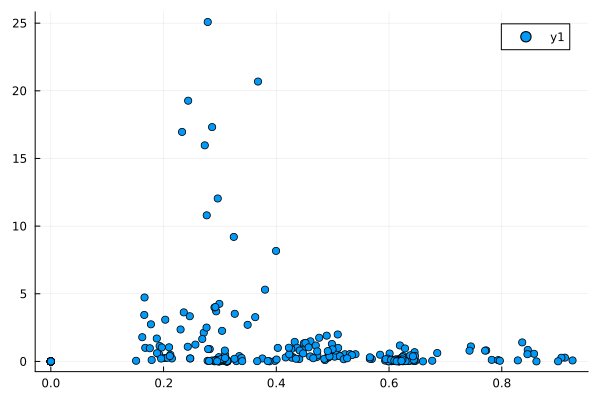

In [55]:
using Plots
scatter(global_nonbind, dif_between_med)

Calculate Correlation between change in median and local sensitivity of kb

In [56]:
augmented_quantiles = deserialize("outputs/600_$(augmented_run)_prediction_quantiles.jls")[1:23]
baseline_quantiles = deserialize("outputs/600_$(baseline_run)_prediction_quantiles.jls")[1:23]
n_outputs = length(augmented_quantiles)
n_timepoints = length(augmented_quantiles[1]["median"])

#calculate absolute difference between medians for each output of interest
difference_between_medians = []
for i in 1:n_outputs
    difference_between_medians = cat(difference_between_medians, [abs.(augmented_quantiles[i]["median"] .- baseline_quantiles[i]["median"])], dims=1)
end

#load local sensitivity to kb for each output of interest
local_sensitivity_kb = deserialize("outputs/600_$(baseline_run)_local_sensitivity_kf.jls");
#maximum across kb
summed_ls_kb = []
for i in 1:n_outputs
    summed_ls_kb = cat(summed_ls_kb, [vec(maximum(abs.(local_sensitivity_kb[i]), dims=2))], dims=1)
end

#reshape for correlation
ls_kb = reshape(Base.stack(summed_ls_kb), n_outputs*n_timepoints)
med_dif = reshape(Base.stack(difference_between_medians), n_outputs*n_timepoints)

pearsons_coef = Statistics.cor(ls_kb, med_dif)

0.22759727984626757